In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import pandas as pd
import datetime as dt

#Also adding pathlib

from pathlib import Path

#Create a reference path to the file.
database_path = Path("../Resources/hawaii.sqlite")

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")
print(engine)

Engine(sqlite:///..\Resources\hawaii.sqlite)


In [40]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine)


In [41]:
# View all of the classes that automap found
automap_found = Base.classes.keys()
print(automap_found)

#Choosing to store as VAR since a list was produced.
print(automap_found[0])
print(automap_found[1])

['measurement', 'station']
measurement
station


In [42]:
# Save references to each table
Measurement = Base.classes.measurement     #Base.classes.automap_found[0].astype("string")
Station = Base.classes.station    #Base.classes.automap_found[1].astype("string")

#print(Station)

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(most_recent_date)

('2017-08-23',)


In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_asTXT = most_recent_date[0]    #.astype("date") ... astype("string") also didn't work ... meh ... 
print(most_recent_asTXT) 
print(type(most_recent_asTXT))  #Confirmed as text ...

Date_TXT_Split = most_recent_asTXT.split("-")    #Orig_Year_series.str.split('-')   #NOTE ... since it's already "str" ... and not in a col ... it doesn't need the ".str" ... bridge to the "split" ... function ... 
print(Date_TXT_Split)

most_recent_asDT = dt.date(year=int(Date_TXT_Split[0]),month=int(Date_TXT_Split[1]),day=int(Date_TXT_Split[2]))
print(most_recent_asDT)
print(type(most_recent_asDT))

# Calculate the date one year from the last date in data set.
one_yr_prior_inclusive = most_recent_asDT - dt.timedelta(days=365)
print(one_yr_prior_inclusive)

# Perform a query to retrieve the data and precipitation scores
#Reviewed data set ... columns needed are titled "date" and "prcp" ... There's also "station" and "tobs" ... 

precipitation_score_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_yr_prior_inclusive).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_col_names = {
     "date" : "Date",
     "prcp" : "Precipitation"
}
precipitation_data_df = pd.DataFrame(data=precipitation_score_data).rename(columns=prcp_col_names)   # , columns=prcp_col_names) #Cannot be within the DF function to rename via a Dict ... 
precipitation_data_df.head()

# Sort the dataframe by date
precipitation_data_df.set_index("Date", inplace=True)
precipitation_data_df.head()

2017-08-23
<class 'str'>
['2017', '08', '23']
2017-08-23
<class 'datetime.date'>
2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [46]:
#Validate the datatypes within the DF for matplotlibs processing needs.

precipitation_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2230 entries, 2016-08-23 to 2017-08-23
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precipitation  2021 non-null   float64
dtypes: float64(1)
memory usage: 34.8+ KB


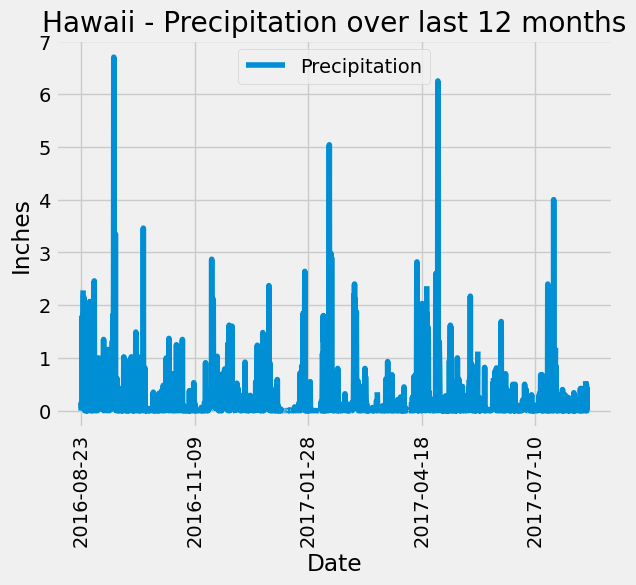

In [47]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = precipitation_data_df.plot(title="Hawaii - Precipitation over last 12 months", rot=90)
prcp_plot.set_xlabel("Date")
prcp_plot.set_ylabel("Inches")
plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_data_df['Precipitation'].describe()

print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [49]:
# Design a query to calculate the total number of stations in the dataset
stations_total_count = session.query(func.count(Station.station)).all()
print(f"The Total Number of Stations in the Stations DataSet is:\n{stations_total_count[0]}")

The Total Number of Stations in the Stations DataSet is:
(9,)


In [50]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations_measured = session.query(Measurement.station, func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()

for station_id, counted in most_active_stations_measured:
    print(f"Measured Station: {station_id}, Dataset Observation Count: {counted}")

Measured Station: USC00519281, Dataset Observation Count: 2772
Measured Station: USC00519397, Dataset Observation Count: 2724
Measured Station: USC00513117, Dataset Observation Count: 2709
Measured Station: USC00519523, Dataset Observation Count: 2669
Measured Station: USC00516128, Dataset Observation Count: 2612
Measured Station: USC00514830, Dataset Observation Count: 2202
Measured Station: USC00511918, Dataset Observation Count: 1979
Measured Station: USC00517948, Dataset Observation Count: 1372
Measured Station: USC00518838, Dataset Observation Count: 511


In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
isolated_most_measured_station = most_active_stations_measured[0][0]

temperature_stats_fetch = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == isolated_most_measured_station).all()

print(temperature_stats_fetch)
print(f"\n+++++++")

isol_lowest_temp, isol_highest_temp, isol_avg_temp = temperature_stats_fetch[0]

print(f"The most measured station from the dataset has the ID of:\n{isolated_most_measured_station}")
print(f"Lowest Temperature: {isol_lowest_temp}")
print(f"Highest Temperature: {isol_highest_temp}")
print(f"Average Temperature: {isol_avg_temp:.2f}")

[(54.0, 85.0, 71.66378066378067)]

+++++++
The most measured station from the dataset has the ID of:
USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


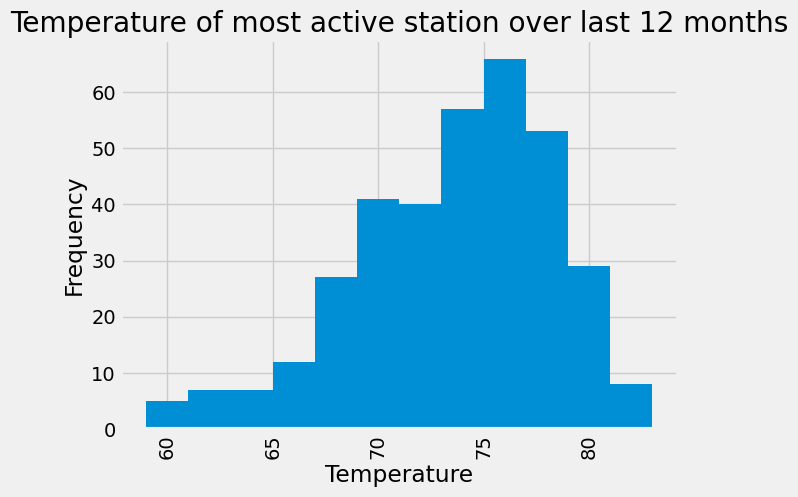

In [52]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_station_data = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= one_yr_prior_inclusive).\
    filter(Measurement.station == isolated_most_measured_station).all()
    
most_station_data

most_station_df = pd.DataFrame(most_station_data, columns = ["Station", "Temperature"])
most_station_df

# Plotting DataFrame
most_station_plot = most_station_df["Temperature"].plot.hist(bins = 12, title="Temperature of most active station over last 12 months", rot=90)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [53]:
# Close Session
session.close()